# ***고양이 수염 스티커 만들기***

## *얼굴 및 랜드마크 검출*

In [47]:
# opencv 및 matplotlib 불러오기

import cv2
import matplotlib.pyplot as plt
import numpy as np

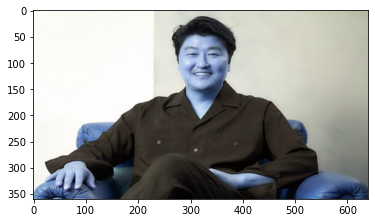

In [48]:
# 셀카 불러오기

import os
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/song.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 360))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

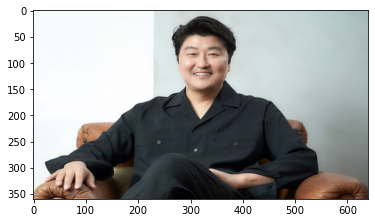

(360, 640, 3)

In [49]:
# bgr로 출력된 사진을 rgb로 변환

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()
img_rgb.shape

In [50]:
# dlib을 사용해서 HOG detector 선언

import dlib
detector_hog = dlib.get_frontal_face_detector() 

In [51]:
# detector로 바운딩박스 추출

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)

rectangles[[(275, 56) (364, 146)]]


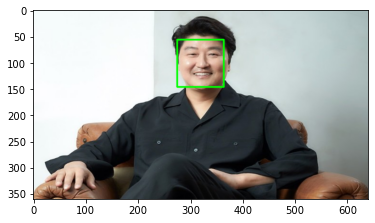

In [52]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## *스티커를 적용할 얼굴 위치 확인*

In [53]:
# Landmark한 모델 불러오기

import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# 랜드마크 프레딕터는 RGB이미지와 dlib.rectangle을 입력받아서 dlib.full_object_detection을 반환

In [54]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

# points함수로 (x, y)형태로 접근할 수 있도록 변환
# list_points는 tuple(x, y) 68개로 이루어진 리스트가 됨

68


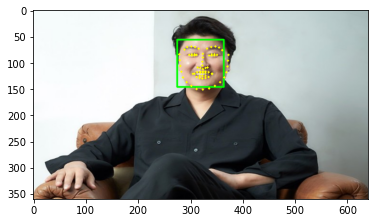

In [55]:
# 랜드마크를 영상에 출력

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## *이미지에 스티커 적용*

In [56]:
# 이미지 좌표 확인하기

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[37][0] - 3
    y = landmark[37][1] + 10
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(323, 105)
(x,y) : (300,94)
(w,h) : (90,90)


In [57]:
# 스티커 이미지 불러와서 적용

import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/mus.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w // 2,h //2)) #스티커 이미지가 약간 커서 줄임.
print (img_sticker.shape)

(45, 45, 3)


x, y 좌표 조정

refined_x = x - w // 2  # left
refined_y = y - h      # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

-y의 크기만큼 스티커 crop

img_sticker = img_sticker[-refined_y:]
print (img_sticker.shape)

y의 좌표가 >=0 이므로 스티커 crop 작업은 생략한다.

y좌표를 원본 이미지의 경계 값으로 수정 

refined_y = 0
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

스티커 이미지가 이미지 경계를 침범하지 않으므로 경계 값으로 수정하는 작업은 생략한다.

In [58]:
# 원본 이미지에 스티커 적용시키기

sticker_area = img_show[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]] # refine 작업을 스킵했기 때문에 그냥 y값과 더해준다
img_show[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

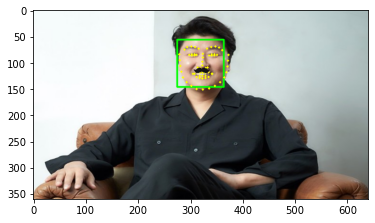

In [59]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

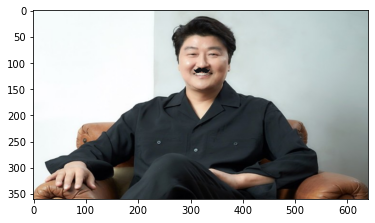

In [60]:

sticker_area = img_bgr[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]]
img_bgr[y:y+img_sticker.shape[0], x:x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()


## *문제점 찾기*

**원래 이미지에 스티커를 적용 시키면서 어려웠거나 까다로웠던 점들은 아래와 같다.**

- 콧수염을 붙이는 프로젝트이지만 사용된 코드나 함수들은 기존에 왕관 스티커를 붙일 때 사용된 코드를 가져왔기 때문에 위치나 크기를 변경해줘야 하는 문제점(?)이 있었다.
   
- 사용된 이미지의 인물 구도나 위치에 따라 스티커 위치를 추가로 수정해 줘야 한다.
   
- 얼굴 각도가 정면으로 된 사진은 y값을 조정함으로써 어느 정도 이미지에 맞출 수 있지만 얼굴 각도가 옆으로 틀어진 경우에는 x값 또한 추가로 변경해 줘야 한다.
   
- 스티커의 위치는 얼굴을 인식해 찍힌 랜드마크를 기준으로 출력이 되므로 우선 원래 이미지 인물의 얼굴을 정확히 인식하는 것이 중요하다.
   
- 기존의 함수를 사용하면 스티커 이미지가 얼굴 상단에 위치를 하게 되어서 y값 좌표를 수정해줘야 하는데 이점이 무척 까다롭고 어려웠다.
   
- 실행속도 측면에서는 프로젝트 수행에 필요한 패키지 설치에 중요하게 작용하지만 그 뒤의 작업부터는 실행속도에 관해서 특별히 번거로웠던 점은 없었던 것 같다.